# Execução do notebook de pre-processamento

Essa execução irá carregar aqui todas as importações e variaveis de ambiente criadas no notebook **preprocessing.ipynb**

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2126 entries, 0 to 2125
Data columns (total 22 columns):
 #   Column                                                  Non-Null Count  Dtype  
---  ------                                                  --------------  -----  
 0   baseline value                                          2126 non-null   float64
 1   accelerations                                           2126 non-null   float64
 2   fetal_movement                                          2126 non-null   float64
 3   uterine_contractions                                    2126 non-null   float64
 4   light_decelerations                                     2126 non-null   float64
 5   severe_decelerations                                    2126 non-null   float64
 6   prolongued_decelerations                                2126 non-null   float64
 7   abnormal_short_term_variability                         2126 non-null   float64
 8   mean_value_of_short_term_variability  

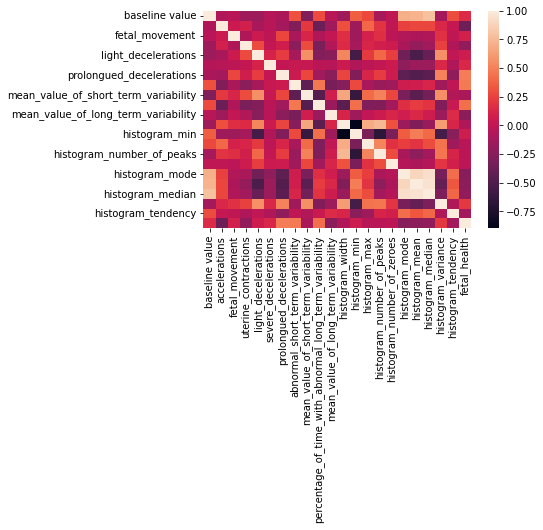

In [1]:
%run preprocessing.ipynb

In [2]:
fetal_health.head()

,baseline value,accelerations,fetal_movement,uterine_contractions,light_decelerations,severe_decelerations,prolongued_decelerations,abnormal_short_term_variability,mean_value_of_short_term_variability,percentage_of_time_with_abnormal_long_term_variability,...,histogram_min,histogram_max,histogram_number_of_peaks,histogram_number_of_zeroes,histogram_mode,histogram_mean,histogram_median,histogram_variance,histogram_tendency,fetal_health
0,120.0,0.000,0.0,0.000,0.000,0.0,0.0,73.0,0.5,43.0,...,62.0,126.0,2.0,0.0,120.0,137.0,121.0,73.0,1.0,2.0
1,132.0,0.006,0.0,0.006,0.003,0.0,0.0,17.0,2.1,0.0,...,68.0,198.0,6.0,1.0,141.0,136.0,140.0,12.0,0.0,1.0
2,133.0,0.003,0.0,0.008,0.003,0.0,0.0,16.0,2.1,0.0,...,68.0,198.0,5.0,1.0,141.0,135.0,138.0,13.0,0.0,1.0
3,134.0,0.003,0.0,0.008,0.003,0.0,0.0,16.0,2.4,0.0,...,53.0,170.0,11.0,0.0,137.0,134.0,137.0,13.0,1.0,1.0
4,132.0,0.007,0.0,0.008,0.000,0.0,0.0,16.0,2.4,0.0,...,53.0,170.0,9.0,0.0,137.0,136.0,138.0,11.0,1.0,1.0


In [3]:
# importe as principais bibliotecas

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

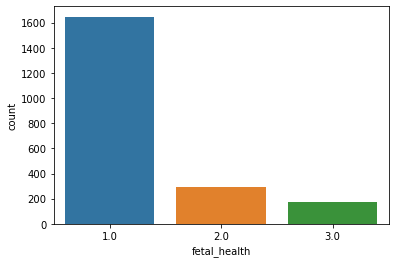

In [4]:
sns.countplot(data=fetal_health, x="fetal_health");

In [5]:
y.value_counts(normalize=True)

1.0    0.778987
2.0    0.138192
3.0    0.082821
Name: fetal_health, dtype: float64

### Legenda:

1 - Normal

2 - Suspeito

3 - Patologico (positivo)

#### Observação importante: Os dados estão bem desbalanceados, mas tendo em vista que o desbalanciamento é exatamente o replexo do cenário atual, onde temos mais fetos normais que suspeitos ou patologico

In [6]:
fetal_health_corr = fetal_health.corr().abs().fetal_health
cols_drops = (fetal_health_corr[fetal_health_corr < 0.08]).index
cols_drops

Index(['light_decelerations', 'histogram_width', 'histogram_min',
       'histogram_max', 'histogram_number_of_peaks',
       'histogram_number_of_zeroes'],
      dtype='object')

In [7]:
X_train.drop(columns=cols_drops, inplace=True)
X_test.drop(columns=cols_drops, inplace=True)

In [105]:
y_pred = fetal_health["fetal_health"].value_counts().index[0]

y_pred

1.0

## Usando o Min Max Scaler

In [73]:
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold, cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, recall_score
from sklearn.metrics import make_scorer, f1_score, r2_score
from sklearn.preprocessing import MinMaxScaler

steps = [
    ("mms", MinMaxScaler()),
    ("knn", KNeighborsClassifier()),
]

pipe = Pipeline(steps)

In [74]:
splitter = KFold(n_splits=10, shuffle=True, random_state=42)

score = make_scorer(recall_score, labels=[2, 3], average="micro")

# ====================

param_grid = {"knn__weights" : ["uniform", "distance"],
              "knn__metric" : ["manhattan", "euclidean"],
              "knn__n_neighbors" : range(2, 40)}

grid_knn_reg = GridSearchCV(estimator=pipe, 
                            param_grid=param_grid,
                            scoring=score,
                            cv=splitter,
                            verbose=10,
                            n_jobs=-1)

grid_knn_reg.fit(X_train, y_train)

Fitting 10 folds for each of 152 candidates, totalling 1520 fits


GridSearchCV(cv=KFold(n_splits=10, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('mms', MinMaxScaler()),
                                       ('knn', KNeighborsClassifier())]),
             n_jobs=-1,
             param_grid={'knn__metric': ['manhattan', 'euclidean'],
                         'knn__n_neighbors': range(2, 40),
                         'knn__weights': ['uniform', 'distance']},
             scoring=make_scorer(recall_score, labels=[2, 3], average=micro),
             verbose=10)

In [75]:
grid_knn_reg.best_params_

{'knn__metric': 'manhattan', 'knn__n_neighbors': 4, 'knn__weights': 'distance'}

In [76]:
from sklearn.metrics import classification_report
pred_train = grid_knn_reg.predict(X_train)

              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00      1316
         2.0       1.00      0.99      1.00       234
         3.0       1.00      1.00      1.00       140

    accuracy                           1.00      1690
   macro avg       1.00      1.00      1.00      1690
weighted avg       1.00      1.00      1.00      1690



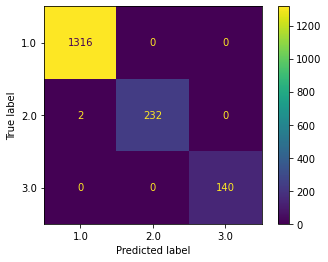

In [77]:
print_report(grid_knn_reg, X_train, y_train)

              precision    recall  f1-score   support

         1.0       0.94      0.98      0.96       330
         2.0       0.77      0.64      0.70        58
         3.0       0.84      0.77      0.81        35

    accuracy                           0.91       423
   macro avg       0.85      0.80      0.82       423
weighted avg       0.91      0.91      0.91       423



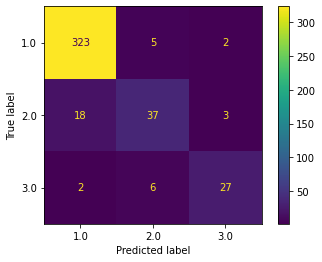

In [78]:
print_report(grid_knn_reg, X_test, y_test)

#### R2

In [79]:
splitter = KFold(n_splits=10, shuffle=True, random_state=42)

score = "r2"

# ====================

param_grid = {"knn__weights" : ["uniform", "distance"],
              "knn__metric" : ["manhattan", "euclidean"],
              "knn__n_neighbors" : range(2, 40)}

grid_knn_reg = GridSearchCV(estimator=pipe, 
                            param_grid=param_grid,
                            scoring=score,
                            cv=splitter,
                            verbose=10,
                            n_jobs=-1)

grid_knn_reg.fit(X_train, y_train)

Fitting 10 folds for each of 152 candidates, totalling 1520 fits


GridSearchCV(cv=KFold(n_splits=10, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('mms', MinMaxScaler()),
                                       ('knn', KNeighborsClassifier())]),
             n_jobs=-1,
             param_grid={'knn__metric': ['manhattan', 'euclidean'],
                         'knn__n_neighbors': range(2, 40),
                         'knn__weights': ['uniform', 'distance']},
             scoring='r2', verbose=10)

#### Accuracy

In [101]:
from sklearn.metrics import accuracy_score

splitter = KFold(n_splits=10, shuffle=True, random_state=42)

score = make_scorer(accuracy_score)

# ====================

param_grid = {"knn__weights" : ['uniform', 'distance'],
              "knn__algorithm" : ['ball_tree', 'brute', 'kd_tree'],
              "knn__metric" : ['manhattan', 'euclidean'],
              "knn__n_neighbors" : range(2, 40)}

grid_knn_reg = GridSearchCV(estimator=pipe, 
                            param_grid=param_grid,
                            scoring=score,
                            cv=splitter,
                            verbose=10,
                            n_jobs=-1)

grid_knn_reg.fit(X_train, y_train) 

Fitting 10 folds for each of 456 candidates, totalling 4560 fits


GridSearchCV(cv=KFold(n_splits=10, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('ss', StandardScaler()),
                                       ('knn', KNeighborsClassifier())]),
             n_jobs=-1,
             param_grid={'knn__algorithm': ['ball_tree', 'brute', 'kd_tree'],
                         'knn__metric': ['manhattan', 'euclidean'],
                         'knn__n_neighbors': range(2, 40),
                         'knn__weights': ['uniform', 'distance']},
             scoring=make_scorer(accuracy_score), verbose=10)

In [102]:
grid_knn_reg.best_params_

{'knn__algorithm': 'ball_tree',
 'knn__metric': 'manhattan',
 'knn__n_neighbors': 4,
 'knn__weights': 'distance'}

              precision    recall  f1-score   support

         1.0       0.94      0.98      0.96       330
         2.0       0.80      0.67      0.73        58
         3.0       0.87      0.74      0.80        35

    accuracy                           0.92       423
   macro avg       0.87      0.80      0.83       423
weighted avg       0.92      0.92      0.92       423



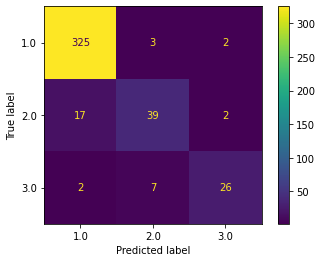

In [103]:
print_report(grid_knn_reg, X_test, y_test)

              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00      1316
         2.0       1.00      0.99      1.00       234
         3.0       1.00      1.00      1.00       140

    accuracy                           1.00      1690
   macro avg       1.00      1.00      1.00      1690
weighted avg       1.00      1.00      1.00      1690



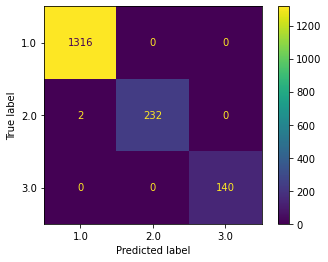

In [104]:
print_report(grid_knn_reg, X_train, y_train)

### Metricas:

r2 = test 91 / train 100

f1 = test 91 / train 95

Accuracy = test 92 / train 100

Recall = test 92 / train 100

## Usando o Standard Scaler

In [95]:
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold, cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, recall_score
from sklearn.metrics import make_scorer, f1_score, r2_score
from sklearn.preprocessing import MinMaxScaler

steps_1 = [
    ("ss", StandardScaler()),
    ("knn", KNeighborsClassifier()),
]

pipe_1 = Pipeline(steps_1)

In [97]:
from sklearn.model_selection import StratifiedKFold

splitter = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

metrica = make_scorer(recall_score, labels=[2, 3], average='micro')


param_grid = {"knn__weights" : ["uniform", "distance"],
              "knn__metric" : ["manhattan", "euclidean"],
              "knn__n_neighbors" : range(2, 40)}


grid_knn = GridSearchCV(estimator=pipe_1, 
                        param_grid=param_grid,
                        scoring=metrica,
                        cv=splitter,
                        verbose=10)

grid_knn.fit(X_train, y_train)

Fitting 10 folds for each of 152 candidates, totalling 1520 fits
[CV 1/10; 1/152] START knn__metric=manhattan, knn__n_neighbors=2, knn__weights=uniform
[CV 1/10; 1/152] END knn__metric=manhattan, knn__n_neighbors=2, knn__weights=uniform;, score=0.676 total time=   0.0s
[CV 2/10; 1/152] START knn__metric=manhattan, knn__n_neighbors=2, knn__weights=uniform
[CV 2/10; 1/152] END knn__metric=manhattan, knn__n_neighbors=2, knn__weights=uniform;, score=0.703 total time=   0.0s
[CV 3/10; 1/152] START knn__metric=manhattan, knn__n_neighbors=2, knn__weights=uniform
[CV 3/10; 1/152] END knn__metric=manhattan, knn__n_neighbors=2, knn__weights=uniform;, score=0.595 total time=   0.0s
[CV 4/10; 1/152] START knn__metric=manhattan, knn__n_neighbors=2, knn__weights=uniform
[CV 4/10; 1/152] END knn__metric=manhattan, knn__n_neighbors=2, knn__weights=uniform;, score=0.595 total time=   0.0s
[CV 5/10; 1/152] START knn__metric=manhattan, knn__n_neighbors=2, knn__weights=uniform
[CV 5/10; 1/152] END knn__me

[CV 1/10; 5/152] END knn__metric=manhattan, knn__n_neighbors=4, knn__weights=uniform;, score=0.595 total time=   0.0s
[CV 2/10; 5/152] START knn__metric=manhattan, knn__n_neighbors=4, knn__weights=uniform
[CV 2/10; 5/152] END knn__metric=manhattan, knn__n_neighbors=4, knn__weights=uniform;, score=0.676 total time=   0.0s
[CV 3/10; 5/152] START knn__metric=manhattan, knn__n_neighbors=4, knn__weights=uniform
[CV 3/10; 5/152] END knn__metric=manhattan, knn__n_neighbors=4, knn__weights=uniform;, score=0.649 total time=   0.0s
[CV 4/10; 5/152] START knn__metric=manhattan, knn__n_neighbors=4, knn__weights=uniform
[CV 4/10; 5/152] END knn__metric=manhattan, knn__n_neighbors=4, knn__weights=uniform;, score=0.595 total time=   0.0s
[CV 5/10; 5/152] START knn__metric=manhattan, knn__n_neighbors=4, knn__weights=uniform
[CV 5/10; 5/152] END knn__metric=manhattan, knn__n_neighbors=4, knn__weights=uniform;, score=0.784 total time=   0.0s
[CV 6/10; 5/152] START knn__metric=manhattan, knn__n_neighbors

[CV 1/10; 9/152] END knn__metric=manhattan, knn__n_neighbors=6, knn__weights=uniform;, score=0.541 total time=   0.0s
[CV 2/10; 9/152] START knn__metric=manhattan, knn__n_neighbors=6, knn__weights=uniform
[CV 2/10; 9/152] END knn__metric=manhattan, knn__n_neighbors=6, knn__weights=uniform;, score=0.649 total time=   0.0s
[CV 3/10; 9/152] START knn__metric=manhattan, knn__n_neighbors=6, knn__weights=uniform
[CV 3/10; 9/152] END knn__metric=manhattan, knn__n_neighbors=6, knn__weights=uniform;, score=0.676 total time=   0.0s
[CV 4/10; 9/152] START knn__metric=manhattan, knn__n_neighbors=6, knn__weights=uniform
[CV 4/10; 9/152] END knn__metric=manhattan, knn__n_neighbors=6, knn__weights=uniform;, score=0.568 total time=   0.0s
[CV 5/10; 9/152] START knn__metric=manhattan, knn__n_neighbors=6, knn__weights=uniform
[CV 5/10; 9/152] END knn__metric=manhattan, knn__n_neighbors=6, knn__weights=uniform;, score=0.784 total time=   0.0s
[CV 6/10; 9/152] START knn__metric=manhattan, knn__n_neighbors

[CV 1/10; 13/152] END knn__metric=manhattan, knn__n_neighbors=8, knn__weights=uniform;, score=0.514 total time=   0.0s
[CV 2/10; 13/152] START knn__metric=manhattan, knn__n_neighbors=8, knn__weights=uniform
[CV 2/10; 13/152] END knn__metric=manhattan, knn__n_neighbors=8, knn__weights=uniform;, score=0.649 total time=   0.0s
[CV 3/10; 13/152] START knn__metric=manhattan, knn__n_neighbors=8, knn__weights=uniform
[CV 3/10; 13/152] END knn__metric=manhattan, knn__n_neighbors=8, knn__weights=uniform;, score=0.649 total time=   0.0s
[CV 4/10; 13/152] START knn__metric=manhattan, knn__n_neighbors=8, knn__weights=uniform
[CV 4/10; 13/152] END knn__metric=manhattan, knn__n_neighbors=8, knn__weights=uniform;, score=0.541 total time=   0.0s
[CV 5/10; 13/152] START knn__metric=manhattan, knn__n_neighbors=8, knn__weights=uniform
[CV 5/10; 13/152] END knn__metric=manhattan, knn__n_neighbors=8, knn__weights=uniform;, score=0.703 total time=   0.0s
[CV 6/10; 13/152] START knn__metric=manhattan, knn__n

[CV 10/10; 17/152] END knn__metric=manhattan, knn__n_neighbors=10, knn__weights=uniform;, score=0.526 total time=   0.0s
[CV 1/10; 18/152] START knn__metric=manhattan, knn__n_neighbors=10, knn__weights=distance
[CV 1/10; 18/152] END knn__metric=manhattan, knn__n_neighbors=10, knn__weights=distance;, score=0.649 total time=   0.0s
[CV 2/10; 18/152] START knn__metric=manhattan, knn__n_neighbors=10, knn__weights=distance
[CV 2/10; 18/152] END knn__metric=manhattan, knn__n_neighbors=10, knn__weights=distance;, score=0.730 total time=   0.0s
[CV 3/10; 18/152] START knn__metric=manhattan, knn__n_neighbors=10, knn__weights=distance
[CV 3/10; 18/152] END knn__metric=manhattan, knn__n_neighbors=10, knn__weights=distance;, score=0.703 total time=   0.0s
[CV 4/10; 18/152] START knn__metric=manhattan, knn__n_neighbors=10, knn__weights=distance
[CV 4/10; 18/152] END knn__metric=manhattan, knn__n_neighbors=10, knn__weights=distance;, score=0.676 total time=   0.0s
[CV 5/10; 18/152] START knn__metric

[CV 10/10; 21/152] END knn__metric=manhattan, knn__n_neighbors=12, knn__weights=uniform;, score=0.500 total time=   0.0s
[CV 1/10; 22/152] START knn__metric=manhattan, knn__n_neighbors=12, knn__weights=distance
[CV 1/10; 22/152] END knn__metric=manhattan, knn__n_neighbors=12, knn__weights=distance;, score=0.595 total time=   0.0s
[CV 2/10; 22/152] START knn__metric=manhattan, knn__n_neighbors=12, knn__weights=distance
[CV 2/10; 22/152] END knn__metric=manhattan, knn__n_neighbors=12, knn__weights=distance;, score=0.757 total time=   0.0s
[CV 3/10; 22/152] START knn__metric=manhattan, knn__n_neighbors=12, knn__weights=distance
[CV 3/10; 22/152] END knn__metric=manhattan, knn__n_neighbors=12, knn__weights=distance;, score=0.703 total time=   0.0s
[CV 4/10; 22/152] START knn__metric=manhattan, knn__n_neighbors=12, knn__weights=distance
[CV 4/10; 22/152] END knn__metric=manhattan, knn__n_neighbors=12, knn__weights=distance;, score=0.703 total time=   0.0s
[CV 5/10; 22/152] START knn__metric

[CV 9/10; 25/152] END knn__metric=manhattan, knn__n_neighbors=14, knn__weights=uniform;, score=0.605 total time=   0.0s
[CV 10/10; 25/152] START knn__metric=manhattan, knn__n_neighbors=14, knn__weights=uniform
[CV 10/10; 25/152] END knn__metric=manhattan, knn__n_neighbors=14, knn__weights=uniform;, score=0.500 total time=   0.0s
[CV 1/10; 26/152] START knn__metric=manhattan, knn__n_neighbors=14, knn__weights=distance
[CV 1/10; 26/152] END knn__metric=manhattan, knn__n_neighbors=14, knn__weights=distance;, score=0.649 total time=   0.0s
[CV 2/10; 26/152] START knn__metric=manhattan, knn__n_neighbors=14, knn__weights=distance
[CV 2/10; 26/152] END knn__metric=manhattan, knn__n_neighbors=14, knn__weights=distance;, score=0.757 total time=   0.0s
[CV 3/10; 26/152] START knn__metric=manhattan, knn__n_neighbors=14, knn__weights=distance
[CV 3/10; 26/152] END knn__metric=manhattan, knn__n_neighbors=14, knn__weights=distance;, score=0.676 total time=   0.0s
[CV 4/10; 26/152] START knn__metric=

[CV 9/10; 29/152] END knn__metric=manhattan, knn__n_neighbors=16, knn__weights=uniform;, score=0.632 total time=   0.0s
[CV 10/10; 29/152] START knn__metric=manhattan, knn__n_neighbors=16, knn__weights=uniform
[CV 10/10; 29/152] END knn__metric=manhattan, knn__n_neighbors=16, knn__weights=uniform;, score=0.500 total time=   0.0s
[CV 1/10; 30/152] START knn__metric=manhattan, knn__n_neighbors=16, knn__weights=distance
[CV 1/10; 30/152] END knn__metric=manhattan, knn__n_neighbors=16, knn__weights=distance;, score=0.649 total time=   0.0s
[CV 2/10; 30/152] START knn__metric=manhattan, knn__n_neighbors=16, knn__weights=distance
[CV 2/10; 30/152] END knn__metric=manhattan, knn__n_neighbors=16, knn__weights=distance;, score=0.757 total time=   0.0s
[CV 3/10; 30/152] START knn__metric=manhattan, knn__n_neighbors=16, knn__weights=distance
[CV 3/10; 30/152] END knn__metric=manhattan, knn__n_neighbors=16, knn__weights=distance;, score=0.676 total time=   0.0s
[CV 4/10; 30/152] START knn__metric=

[CV 9/10; 33/152] END knn__metric=manhattan, knn__n_neighbors=18, knn__weights=uniform;, score=0.553 total time=   0.0s
[CV 10/10; 33/152] START knn__metric=manhattan, knn__n_neighbors=18, knn__weights=uniform
[CV 10/10; 33/152] END knn__metric=manhattan, knn__n_neighbors=18, knn__weights=uniform;, score=0.500 total time=   0.0s
[CV 1/10; 34/152] START knn__metric=manhattan, knn__n_neighbors=18, knn__weights=distance
[CV 1/10; 34/152] END knn__metric=manhattan, knn__n_neighbors=18, knn__weights=distance;, score=0.622 total time=   0.0s
[CV 2/10; 34/152] START knn__metric=manhattan, knn__n_neighbors=18, knn__weights=distance
[CV 2/10; 34/152] END knn__metric=manhattan, knn__n_neighbors=18, knn__weights=distance;, score=0.730 total time=   0.0s
[CV 3/10; 34/152] START knn__metric=manhattan, knn__n_neighbors=18, knn__weights=distance
[CV 3/10; 34/152] END knn__metric=manhattan, knn__n_neighbors=18, knn__weights=distance;, score=0.676 total time=   0.0s
[CV 4/10; 34/152] START knn__metric=

[CV 9/10; 37/152] END knn__metric=manhattan, knn__n_neighbors=20, knn__weights=uniform;, score=0.526 total time=   0.0s
[CV 10/10; 37/152] START knn__metric=manhattan, knn__n_neighbors=20, knn__weights=uniform
[CV 10/10; 37/152] END knn__metric=manhattan, knn__n_neighbors=20, knn__weights=uniform;, score=0.500 total time=   0.0s
[CV 1/10; 38/152] START knn__metric=manhattan, knn__n_neighbors=20, knn__weights=distance
[CV 1/10; 38/152] END knn__metric=manhattan, knn__n_neighbors=20, knn__weights=distance;, score=0.649 total time=   0.0s
[CV 2/10; 38/152] START knn__metric=manhattan, knn__n_neighbors=20, knn__weights=distance
[CV 2/10; 38/152] END knn__metric=manhattan, knn__n_neighbors=20, knn__weights=distance;, score=0.703 total time=   0.0s
[CV 3/10; 38/152] START knn__metric=manhattan, knn__n_neighbors=20, knn__weights=distance
[CV 3/10; 38/152] END knn__metric=manhattan, knn__n_neighbors=20, knn__weights=distance;, score=0.676 total time=   0.0s
[CV 4/10; 38/152] START knn__metric=

[CV 8/10; 41/152] END knn__metric=manhattan, knn__n_neighbors=22, knn__weights=uniform;, score=0.737 total time=   0.0s
[CV 9/10; 41/152] START knn__metric=manhattan, knn__n_neighbors=22, knn__weights=uniform
[CV 9/10; 41/152] END knn__metric=manhattan, knn__n_neighbors=22, knn__weights=uniform;, score=0.553 total time=   0.0s
[CV 10/10; 41/152] START knn__metric=manhattan, knn__n_neighbors=22, knn__weights=uniform
[CV 10/10; 41/152] END knn__metric=manhattan, knn__n_neighbors=22, knn__weights=uniform;, score=0.553 total time=   0.0s
[CV 1/10; 42/152] START knn__metric=manhattan, knn__n_neighbors=22, knn__weights=distance
[CV 1/10; 42/152] END knn__metric=manhattan, knn__n_neighbors=22, knn__weights=distance;, score=0.622 total time=   0.0s
[CV 2/10; 42/152] START knn__metric=manhattan, knn__n_neighbors=22, knn__weights=distance
[CV 2/10; 42/152] END knn__metric=manhattan, knn__n_neighbors=22, knn__weights=distance;, score=0.703 total time=   0.0s
[CV 3/10; 42/152] START knn__metric=ma

[CV 7/10; 46/152] END knn__metric=manhattan, knn__n_neighbors=24, knn__weights=distance;, score=0.605 total time=   0.0s
[CV 8/10; 46/152] START knn__metric=manhattan, knn__n_neighbors=24, knn__weights=distance
[CV 8/10; 46/152] END knn__metric=manhattan, knn__n_neighbors=24, knn__weights=distance;, score=0.763 total time=   0.0s
[CV 9/10; 46/152] START knn__metric=manhattan, knn__n_neighbors=24, knn__weights=distance
[CV 9/10; 46/152] END knn__metric=manhattan, knn__n_neighbors=24, knn__weights=distance;, score=0.684 total time=   0.0s
[CV 10/10; 46/152] START knn__metric=manhattan, knn__n_neighbors=24, knn__weights=distance
[CV 10/10; 46/152] END knn__metric=manhattan, knn__n_neighbors=24, knn__weights=distance;, score=0.605 total time=   0.0s
[CV 1/10; 47/152] START knn__metric=manhattan, knn__n_neighbors=25, knn__weights=uniform
[CV 1/10; 47/152] END knn__metric=manhattan, knn__n_neighbors=25, knn__weights=uniform;, score=0.568 total time=   0.0s
[CV 2/10; 47/152] START knn__metric

[CV 6/10; 50/152] END knn__metric=manhattan, knn__n_neighbors=26, knn__weights=distance;, score=0.595 total time=   0.0s
[CV 7/10; 50/152] START knn__metric=manhattan, knn__n_neighbors=26, knn__weights=distance
[CV 7/10; 50/152] END knn__metric=manhattan, knn__n_neighbors=26, knn__weights=distance;, score=0.579 total time=   0.0s
[CV 8/10; 50/152] START knn__metric=manhattan, knn__n_neighbors=26, knn__weights=distance
[CV 8/10; 50/152] END knn__metric=manhattan, knn__n_neighbors=26, knn__weights=distance;, score=0.763 total time=   0.0s
[CV 9/10; 50/152] START knn__metric=manhattan, knn__n_neighbors=26, knn__weights=distance
[CV 9/10; 50/152] END knn__metric=manhattan, knn__n_neighbors=26, knn__weights=distance;, score=0.711 total time=   0.0s
[CV 10/10; 50/152] START knn__metric=manhattan, knn__n_neighbors=26, knn__weights=distance
[CV 10/10; 50/152] END knn__metric=manhattan, knn__n_neighbors=26, knn__weights=distance;, score=0.605 total time=   0.0s
[CV 1/10; 51/152] START knn__metr

[CV 7/10; 55/152] END knn__metric=manhattan, knn__n_neighbors=29, knn__weights=uniform;, score=0.526 total time=   0.0s
[CV 8/10; 55/152] START knn__metric=manhattan, knn__n_neighbors=29, knn__weights=uniform
[CV 8/10; 55/152] END knn__metric=manhattan, knn__n_neighbors=29, knn__weights=uniform;, score=0.737 total time=   0.0s
[CV 9/10; 55/152] START knn__metric=manhattan, knn__n_neighbors=29, knn__weights=uniform
[CV 9/10; 55/152] END knn__metric=manhattan, knn__n_neighbors=29, knn__weights=uniform;, score=0.658 total time=   0.0s
[CV 10/10; 55/152] START knn__metric=manhattan, knn__n_neighbors=29, knn__weights=uniform
[CV 10/10; 55/152] END knn__metric=manhattan, knn__n_neighbors=29, knn__weights=uniform;, score=0.526 total time=   0.0s
[CV 1/10; 56/152] START knn__metric=manhattan, knn__n_neighbors=29, knn__weights=distance
[CV 1/10; 56/152] END knn__metric=manhattan, knn__n_neighbors=29, knn__weights=distance;, score=0.649 total time=   0.0s
[CV 2/10; 56/152] START knn__metric=manh

[CV 8/10; 60/152] END knn__metric=manhattan, knn__n_neighbors=31, knn__weights=distance;, score=0.763 total time=   0.0s
[CV 9/10; 60/152] START knn__metric=manhattan, knn__n_neighbors=31, knn__weights=distance
[CV 9/10; 60/152] END knn__metric=manhattan, knn__n_neighbors=31, knn__weights=distance;, score=0.711 total time=   0.0s
[CV 10/10; 60/152] START knn__metric=manhattan, knn__n_neighbors=31, knn__weights=distance
[CV 10/10; 60/152] END knn__metric=manhattan, knn__n_neighbors=31, knn__weights=distance;, score=0.605 total time=   0.0s
[CV 1/10; 61/152] START knn__metric=manhattan, knn__n_neighbors=32, knn__weights=uniform
[CV 1/10; 61/152] END knn__metric=manhattan, knn__n_neighbors=32, knn__weights=uniform;, score=0.541 total time=   0.0s
[CV 2/10; 61/152] START knn__metric=manhattan, knn__n_neighbors=32, knn__weights=uniform
[CV 2/10; 61/152] END knn__metric=manhattan, knn__n_neighbors=32, knn__weights=uniform;, score=0.676 total time=   0.0s
[CV 3/10; 61/152] START knn__metric=m

[CV 9/10; 65/152] END knn__metric=manhattan, knn__n_neighbors=34, knn__weights=uniform;, score=0.632 total time=   0.0s
[CV 10/10; 65/152] START knn__metric=manhattan, knn__n_neighbors=34, knn__weights=uniform
[CV 10/10; 65/152] END knn__metric=manhattan, knn__n_neighbors=34, knn__weights=uniform;, score=0.500 total time=   0.0s
[CV 1/10; 66/152] START knn__metric=manhattan, knn__n_neighbors=34, knn__weights=distance
[CV 1/10; 66/152] END knn__metric=manhattan, knn__n_neighbors=34, knn__weights=distance;, score=0.622 total time=   0.0s
[CV 2/10; 66/152] START knn__metric=manhattan, knn__n_neighbors=34, knn__weights=distance
[CV 2/10; 66/152] END knn__metric=manhattan, knn__n_neighbors=34, knn__weights=distance;, score=0.730 total time=   0.0s
[CV 3/10; 66/152] START knn__metric=manhattan, knn__n_neighbors=34, knn__weights=distance
[CV 3/10; 66/152] END knn__metric=manhattan, knn__n_neighbors=34, knn__weights=distance;, score=0.676 total time=   0.0s
[CV 4/10; 66/152] START knn__metric=

[CV 10/10; 70/152] END knn__metric=manhattan, knn__n_neighbors=36, knn__weights=distance;, score=0.605 total time=   0.0s
[CV 1/10; 71/152] START knn__metric=manhattan, knn__n_neighbors=37, knn__weights=uniform
[CV 1/10; 71/152] END knn__metric=manhattan, knn__n_neighbors=37, knn__weights=uniform;, score=0.541 total time=   0.0s
[CV 2/10; 71/152] START knn__metric=manhattan, knn__n_neighbors=37, knn__weights=uniform
[CV 2/10; 71/152] END knn__metric=manhattan, knn__n_neighbors=37, knn__weights=uniform;, score=0.649 total time=   0.0s
[CV 3/10; 71/152] START knn__metric=manhattan, knn__n_neighbors=37, knn__weights=uniform
[CV 3/10; 71/152] END knn__metric=manhattan, knn__n_neighbors=37, knn__weights=uniform;, score=0.649 total time=   0.0s
[CV 4/10; 71/152] START knn__metric=manhattan, knn__n_neighbors=37, knn__weights=uniform
[CV 4/10; 71/152] END knn__metric=manhattan, knn__n_neighbors=37, knn__weights=uniform;, score=0.676 total time=   0.0s
[CV 5/10; 71/152] START knn__metric=manhat

[CV 10/10; 75/152] END knn__metric=manhattan, knn__n_neighbors=39, knn__weights=uniform;, score=0.500 total time=   0.0s
[CV 1/10; 76/152] START knn__metric=manhattan, knn__n_neighbors=39, knn__weights=distance
[CV 1/10; 76/152] END knn__metric=manhattan, knn__n_neighbors=39, knn__weights=distance;, score=0.595 total time=   0.0s
[CV 2/10; 76/152] START knn__metric=manhattan, knn__n_neighbors=39, knn__weights=distance
[CV 2/10; 76/152] END knn__metric=manhattan, knn__n_neighbors=39, knn__weights=distance;, score=0.703 total time=   0.0s
[CV 3/10; 76/152] START knn__metric=manhattan, knn__n_neighbors=39, knn__weights=distance
[CV 3/10; 76/152] END knn__metric=manhattan, knn__n_neighbors=39, knn__weights=distance;, score=0.703 total time=   0.0s
[CV 4/10; 76/152] START knn__metric=manhattan, knn__n_neighbors=39, knn__weights=distance
[CV 4/10; 76/152] END knn__metric=manhattan, knn__n_neighbors=39, knn__weights=distance;, score=0.730 total time=   0.0s
[CV 5/10; 76/152] START knn__metric

[CV 3/10; 81/152] END knn__metric=euclidean, knn__n_neighbors=4, knn__weights=uniform;, score=0.595 total time=   0.0s
[CV 4/10; 81/152] START knn__metric=euclidean, knn__n_neighbors=4, knn__weights=uniform
[CV 4/10; 81/152] END knn__metric=euclidean, knn__n_neighbors=4, knn__weights=uniform;, score=0.649 total time=   0.0s
[CV 5/10; 81/152] START knn__metric=euclidean, knn__n_neighbors=4, knn__weights=uniform
[CV 5/10; 81/152] END knn__metric=euclidean, knn__n_neighbors=4, knn__weights=uniform;, score=0.757 total time=   0.0s
[CV 6/10; 81/152] START knn__metric=euclidean, knn__n_neighbors=4, knn__weights=uniform
[CV 6/10; 81/152] END knn__metric=euclidean, knn__n_neighbors=4, knn__weights=uniform;, score=0.595 total time=   0.0s
[CV 7/10; 81/152] START knn__metric=euclidean, knn__n_neighbors=4, knn__weights=uniform
[CV 7/10; 81/152] END knn__metric=euclidean, knn__n_neighbors=4, knn__weights=uniform;, score=0.500 total time=   0.0s
[CV 8/10; 81/152] START knn__metric=euclidean, knn__n

[CV 3/10; 85/152] END knn__metric=euclidean, knn__n_neighbors=6, knn__weights=uniform;, score=0.622 total time=   0.0s
[CV 4/10; 85/152] START knn__metric=euclidean, knn__n_neighbors=6, knn__weights=uniform
[CV 4/10; 85/152] END knn__metric=euclidean, knn__n_neighbors=6, knn__weights=uniform;, score=0.595 total time=   0.0s
[CV 5/10; 85/152] START knn__metric=euclidean, knn__n_neighbors=6, knn__weights=uniform
[CV 5/10; 85/152] END knn__metric=euclidean, knn__n_neighbors=6, knn__weights=uniform;, score=0.622 total time=   0.0s
[CV 6/10; 85/152] START knn__metric=euclidean, knn__n_neighbors=6, knn__weights=uniform
[CV 6/10; 85/152] END knn__metric=euclidean, knn__n_neighbors=6, knn__weights=uniform;, score=0.568 total time=   0.0s
[CV 7/10; 85/152] START knn__metric=euclidean, knn__n_neighbors=6, knn__weights=uniform
[CV 7/10; 85/152] END knn__metric=euclidean, knn__n_neighbors=6, knn__weights=uniform;, score=0.553 total time=   0.0s
[CV 8/10; 85/152] START knn__metric=euclidean, knn__n

[CV 4/10; 90/152] END knn__metric=euclidean, knn__n_neighbors=8, knn__weights=distance;, score=0.730 total time=   0.0s
[CV 5/10; 90/152] START knn__metric=euclidean, knn__n_neighbors=8, knn__weights=distance
[CV 5/10; 90/152] END knn__metric=euclidean, knn__n_neighbors=8, knn__weights=distance;, score=0.838 total time=   0.0s
[CV 6/10; 90/152] START knn__metric=euclidean, knn__n_neighbors=8, knn__weights=distance
[CV 6/10; 90/152] END knn__metric=euclidean, knn__n_neighbors=8, knn__weights=distance;, score=0.703 total time=   0.0s
[CV 7/10; 90/152] START knn__metric=euclidean, knn__n_neighbors=8, knn__weights=distance
[CV 7/10; 90/152] END knn__metric=euclidean, knn__n_neighbors=8, knn__weights=distance;, score=0.658 total time=   0.0s
[CV 8/10; 90/152] START knn__metric=euclidean, knn__n_neighbors=8, knn__weights=distance
[CV 8/10; 90/152] END knn__metric=euclidean, knn__n_neighbors=8, knn__weights=distance;, score=0.868 total time=   0.0s
[CV 9/10; 90/152] START knn__metric=euclidea

[CV 6/10; 95/152] END knn__metric=euclidean, knn__n_neighbors=11, knn__weights=uniform;, score=0.649 total time=   0.0s
[CV 7/10; 95/152] START knn__metric=euclidean, knn__n_neighbors=11, knn__weights=uniform
[CV 7/10; 95/152] END knn__metric=euclidean, knn__n_neighbors=11, knn__weights=uniform;, score=0.605 total time=   0.0s
[CV 8/10; 95/152] START knn__metric=euclidean, knn__n_neighbors=11, knn__weights=uniform
[CV 8/10; 95/152] END knn__metric=euclidean, knn__n_neighbors=11, knn__weights=uniform;, score=0.763 total time=   0.0s
[CV 9/10; 95/152] START knn__metric=euclidean, knn__n_neighbors=11, knn__weights=uniform
[CV 9/10; 95/152] END knn__metric=euclidean, knn__n_neighbors=11, knn__weights=uniform;, score=0.605 total time=   0.0s
[CV 10/10; 95/152] START knn__metric=euclidean, knn__n_neighbors=11, knn__weights=uniform
[CV 10/10; 95/152] END knn__metric=euclidean, knn__n_neighbors=11, knn__weights=uniform;, score=0.526 total time=   0.0s
[CV 1/10; 96/152] START knn__metric=euclid

[CV 5/10; 99/152] END knn__metric=euclidean, knn__n_neighbors=13, knn__weights=uniform;, score=0.730 total time=   0.0s
[CV 6/10; 99/152] START knn__metric=euclidean, knn__n_neighbors=13, knn__weights=uniform
[CV 6/10; 99/152] END knn__metric=euclidean, knn__n_neighbors=13, knn__weights=uniform;, score=0.595 total time=   0.0s
[CV 7/10; 99/152] START knn__metric=euclidean, knn__n_neighbors=13, knn__weights=uniform
[CV 7/10; 99/152] END knn__metric=euclidean, knn__n_neighbors=13, knn__weights=uniform;, score=0.579 total time=   0.0s
[CV 8/10; 99/152] START knn__metric=euclidean, knn__n_neighbors=13, knn__weights=uniform
[CV 8/10; 99/152] END knn__metric=euclidean, knn__n_neighbors=13, knn__weights=uniform;, score=0.789 total time=   0.0s
[CV 9/10; 99/152] START knn__metric=euclidean, knn__n_neighbors=13, knn__weights=uniform
[CV 9/10; 99/152] END knn__metric=euclidean, knn__n_neighbors=13, knn__weights=uniform;, score=0.605 total time=   0.0s
[CV 10/10; 99/152] START knn__metric=euclide

[CV 4/10; 104/152] END knn__metric=euclidean, knn__n_neighbors=15, knn__weights=distance;, score=0.676 total time=   0.0s
[CV 5/10; 104/152] START knn__metric=euclidean, knn__n_neighbors=15, knn__weights=distance
[CV 5/10; 104/152] END knn__metric=euclidean, knn__n_neighbors=15, knn__weights=distance;, score=0.784 total time=   0.0s
[CV 6/10; 104/152] START knn__metric=euclidean, knn__n_neighbors=15, knn__weights=distance
[CV 6/10; 104/152] END knn__metric=euclidean, knn__n_neighbors=15, knn__weights=distance;, score=0.595 total time=   0.0s
[CV 7/10; 104/152] START knn__metric=euclidean, knn__n_neighbors=15, knn__weights=distance
[CV 7/10; 104/152] END knn__metric=euclidean, knn__n_neighbors=15, knn__weights=distance;, score=0.605 total time=   0.0s
[CV 8/10; 104/152] START knn__metric=euclidean, knn__n_neighbors=15, knn__weights=distance
[CV 8/10; 104/152] END knn__metric=euclidean, knn__n_neighbors=15, knn__weights=distance;, score=0.789 total time=   0.0s
[CV 9/10; 104/152] START k

[CV 2/10; 109/152] END knn__metric=euclidean, knn__n_neighbors=18, knn__weights=uniform;, score=0.676 total time=   0.0s
[CV 3/10; 109/152] START knn__metric=euclidean, knn__n_neighbors=18, knn__weights=uniform
[CV 3/10; 109/152] END knn__metric=euclidean, knn__n_neighbors=18, knn__weights=uniform;, score=0.649 total time=   0.0s
[CV 4/10; 109/152] START knn__metric=euclidean, knn__n_neighbors=18, knn__weights=uniform
[CV 4/10; 109/152] END knn__metric=euclidean, knn__n_neighbors=18, knn__weights=uniform;, score=0.595 total time=   0.0s
[CV 5/10; 109/152] START knn__metric=euclidean, knn__n_neighbors=18, knn__weights=uniform
[CV 5/10; 109/152] END knn__metric=euclidean, knn__n_neighbors=18, knn__weights=uniform;, score=0.703 total time=   0.0s
[CV 6/10; 109/152] START knn__metric=euclidean, knn__n_neighbors=18, knn__weights=uniform
[CV 6/10; 109/152] END knn__metric=euclidean, knn__n_neighbors=18, knn__weights=uniform;, score=0.568 total time=   0.0s
[CV 7/10; 109/152] START knn__metri

[CV 9/10; 113/152] END knn__metric=euclidean, knn__n_neighbors=20, knn__weights=uniform;, score=0.579 total time=   0.0s
[CV 10/10; 113/152] START knn__metric=euclidean, knn__n_neighbors=20, knn__weights=uniform
[CV 10/10; 113/152] END knn__metric=euclidean, knn__n_neighbors=20, knn__weights=uniform;, score=0.526 total time=   0.0s
[CV 1/10; 114/152] START knn__metric=euclidean, knn__n_neighbors=20, knn__weights=distance
[CV 1/10; 114/152] END knn__metric=euclidean, knn__n_neighbors=20, knn__weights=distance;, score=0.622 total time=   0.0s
[CV 2/10; 114/152] START knn__metric=euclidean, knn__n_neighbors=20, knn__weights=distance
[CV 2/10; 114/152] END knn__metric=euclidean, knn__n_neighbors=20, knn__weights=distance;, score=0.649 total time=   0.0s
[CV 3/10; 114/152] START knn__metric=euclidean, knn__n_neighbors=20, knn__weights=distance
[CV 3/10; 114/152] END knn__metric=euclidean, knn__n_neighbors=20, knn__weights=distance;, score=0.676 total time=   0.0s
[CV 4/10; 114/152] START kn

[CV 9/10; 118/152] END knn__metric=euclidean, knn__n_neighbors=22, knn__weights=distance;, score=0.632 total time=   0.0s
[CV 10/10; 118/152] START knn__metric=euclidean, knn__n_neighbors=22, knn__weights=distance
[CV 10/10; 118/152] END knn__metric=euclidean, knn__n_neighbors=22, knn__weights=distance;, score=0.605 total time=   0.0s
[CV 1/10; 119/152] START knn__metric=euclidean, knn__n_neighbors=23, knn__weights=uniform
[CV 1/10; 119/152] END knn__metric=euclidean, knn__n_neighbors=23, knn__weights=uniform;, score=0.541 total time=   0.0s
[CV 2/10; 119/152] START knn__metric=euclidean, knn__n_neighbors=23, knn__weights=uniform
[CV 2/10; 119/152] END knn__metric=euclidean, knn__n_neighbors=23, knn__weights=uniform;, score=0.676 total time=   0.0s
[CV 3/10; 119/152] START knn__metric=euclidean, knn__n_neighbors=23, knn__weights=uniform
[CV 3/10; 119/152] END knn__metric=euclidean, knn__n_neighbors=23, knn__weights=uniform;, score=0.595 total time=   0.0s
[CV 4/10; 119/152] START knn__

[CV 5/10; 123/152] END knn__metric=euclidean, knn__n_neighbors=25, knn__weights=uniform;, score=0.649 total time=   0.0s
[CV 6/10; 123/152] START knn__metric=euclidean, knn__n_neighbors=25, knn__weights=uniform
[CV 6/10; 123/152] END knn__metric=euclidean, knn__n_neighbors=25, knn__weights=uniform;, score=0.541 total time=   0.0s
[CV 7/10; 123/152] START knn__metric=euclidean, knn__n_neighbors=25, knn__weights=uniform
[CV 7/10; 123/152] END knn__metric=euclidean, knn__n_neighbors=25, knn__weights=uniform;, score=0.500 total time=   0.0s
[CV 8/10; 123/152] START knn__metric=euclidean, knn__n_neighbors=25, knn__weights=uniform
[CV 8/10; 123/152] END knn__metric=euclidean, knn__n_neighbors=25, knn__weights=uniform;, score=0.763 total time=   0.0s
[CV 9/10; 123/152] START knn__metric=euclidean, knn__n_neighbors=25, knn__weights=uniform
[CV 9/10; 123/152] END knn__metric=euclidean, knn__n_neighbors=25, knn__weights=uniform;, score=0.579 total time=   0.0s
[CV 10/10; 123/152] START knn__metr

[CV 2/10; 128/152] END knn__metric=euclidean, knn__n_neighbors=27, knn__weights=distance;, score=0.649 total time=   0.0s
[CV 3/10; 128/152] START knn__metric=euclidean, knn__n_neighbors=27, knn__weights=distance
[CV 3/10; 128/152] END knn__metric=euclidean, knn__n_neighbors=27, knn__weights=distance;, score=0.649 total time=   0.0s
[CV 4/10; 128/152] START knn__metric=euclidean, knn__n_neighbors=27, knn__weights=distance
[CV 4/10; 128/152] END knn__metric=euclidean, knn__n_neighbors=27, knn__weights=distance;, score=0.649 total time=   0.0s
[CV 5/10; 128/152] START knn__metric=euclidean, knn__n_neighbors=27, knn__weights=distance
[CV 5/10; 128/152] END knn__metric=euclidean, knn__n_neighbors=27, knn__weights=distance;, score=0.730 total time=   0.0s
[CV 6/10; 128/152] START knn__metric=euclidean, knn__n_neighbors=27, knn__weights=distance
[CV 6/10; 128/152] END knn__metric=euclidean, knn__n_neighbors=27, knn__weights=distance;, score=0.568 total time=   0.0s
[CV 7/10; 128/152] START k

[CV 9/10; 132/152] END knn__metric=euclidean, knn__n_neighbors=29, knn__weights=distance;, score=0.632 total time=   0.0s
[CV 10/10; 132/152] START knn__metric=euclidean, knn__n_neighbors=29, knn__weights=distance
[CV 10/10; 132/152] END knn__metric=euclidean, knn__n_neighbors=29, knn__weights=distance;, score=0.579 total time=   0.0s
[CV 1/10; 133/152] START knn__metric=euclidean, knn__n_neighbors=30, knn__weights=uniform
[CV 1/10; 133/152] END knn__metric=euclidean, knn__n_neighbors=30, knn__weights=uniform;, score=0.514 total time=   0.0s
[CV 2/10; 133/152] START knn__metric=euclidean, knn__n_neighbors=30, knn__weights=uniform
[CV 2/10; 133/152] END knn__metric=euclidean, knn__n_neighbors=30, knn__weights=uniform;, score=0.622 total time=   0.0s
[CV 3/10; 133/152] START knn__metric=euclidean, knn__n_neighbors=30, knn__weights=uniform
[CV 3/10; 133/152] END knn__metric=euclidean, knn__n_neighbors=30, knn__weights=uniform;, score=0.622 total time=   0.0s
[CV 4/10; 133/152] START knn__

[CV 4/10; 137/152] END knn__metric=euclidean, knn__n_neighbors=32, knn__weights=uniform;, score=0.649 total time=   0.0s
[CV 5/10; 137/152] START knn__metric=euclidean, knn__n_neighbors=32, knn__weights=uniform
[CV 5/10; 137/152] END knn__metric=euclidean, knn__n_neighbors=32, knn__weights=uniform;, score=0.649 total time=   0.0s
[CV 6/10; 137/152] START knn__metric=euclidean, knn__n_neighbors=32, knn__weights=uniform
[CV 6/10; 137/152] END knn__metric=euclidean, knn__n_neighbors=32, knn__weights=uniform;, score=0.514 total time=   0.0s
[CV 7/10; 137/152] START knn__metric=euclidean, knn__n_neighbors=32, knn__weights=uniform
[CV 7/10; 137/152] END knn__metric=euclidean, knn__n_neighbors=32, knn__weights=uniform;, score=0.526 total time=   0.0s
[CV 8/10; 137/152] START knn__metric=euclidean, knn__n_neighbors=32, knn__weights=uniform
[CV 8/10; 137/152] END knn__metric=euclidean, knn__n_neighbors=32, knn__weights=uniform;, score=0.737 total time=   0.0s
[CV 9/10; 137/152] START knn__metri

[CV 2/10; 142/152] END knn__metric=euclidean, knn__n_neighbors=34, knn__weights=distance;, score=0.703 total time=   0.0s
[CV 3/10; 142/152] START knn__metric=euclidean, knn__n_neighbors=34, knn__weights=distance
[CV 3/10; 142/152] END knn__metric=euclidean, knn__n_neighbors=34, knn__weights=distance;, score=0.649 total time=   0.0s
[CV 4/10; 142/152] START knn__metric=euclidean, knn__n_neighbors=34, knn__weights=distance
[CV 4/10; 142/152] END knn__metric=euclidean, knn__n_neighbors=34, knn__weights=distance;, score=0.649 total time=   0.0s
[CV 5/10; 142/152] START knn__metric=euclidean, knn__n_neighbors=34, knn__weights=distance
[CV 5/10; 142/152] END knn__metric=euclidean, knn__n_neighbors=34, knn__weights=distance;, score=0.730 total time=   0.0s
[CV 6/10; 142/152] START knn__metric=euclidean, knn__n_neighbors=34, knn__weights=distance
[CV 6/10; 142/152] END knn__metric=euclidean, knn__n_neighbors=34, knn__weights=distance;, score=0.541 total time=   0.0s
[CV 7/10; 142/152] START k

[CV 10/10; 146/152] END knn__metric=euclidean, knn__n_neighbors=36, knn__weights=distance;, score=0.579 total time=   0.0s
[CV 1/10; 147/152] START knn__metric=euclidean, knn__n_neighbors=37, knn__weights=uniform
[CV 1/10; 147/152] END knn__metric=euclidean, knn__n_neighbors=37, knn__weights=uniform;, score=0.514 total time=   0.0s
[CV 2/10; 147/152] START knn__metric=euclidean, knn__n_neighbors=37, knn__weights=uniform
[CV 2/10; 147/152] END knn__metric=euclidean, knn__n_neighbors=37, knn__weights=uniform;, score=0.676 total time=   0.0s
[CV 3/10; 147/152] START knn__metric=euclidean, knn__n_neighbors=37, knn__weights=uniform
[CV 3/10; 147/152] END knn__metric=euclidean, knn__n_neighbors=37, knn__weights=uniform;, score=0.622 total time=   0.0s
[CV 4/10; 147/152] START knn__metric=euclidean, knn__n_neighbors=37, knn__weights=uniform
[CV 4/10; 147/152] END knn__metric=euclidean, knn__n_neighbors=37, knn__weights=uniform;, score=0.676 total time=   0.0s
[CV 5/10; 147/152] START knn__met

[CV 6/10; 151/152] END knn__metric=euclidean, knn__n_neighbors=39, knn__weights=uniform;, score=0.514 total time=   0.0s
[CV 7/10; 151/152] START knn__metric=euclidean, knn__n_neighbors=39, knn__weights=uniform
[CV 7/10; 151/152] END knn__metric=euclidean, knn__n_neighbors=39, knn__weights=uniform;, score=0.553 total time=   0.0s
[CV 8/10; 151/152] START knn__metric=euclidean, knn__n_neighbors=39, knn__weights=uniform
[CV 8/10; 151/152] END knn__metric=euclidean, knn__n_neighbors=39, knn__weights=uniform;, score=0.737 total time=   0.0s
[CV 9/10; 151/152] START knn__metric=euclidean, knn__n_neighbors=39, knn__weights=uniform
[CV 9/10; 151/152] END knn__metric=euclidean, knn__n_neighbors=39, knn__weights=uniform;, score=0.579 total time=   0.0s
[CV 10/10; 151/152] START knn__metric=euclidean, knn__n_neighbors=39, knn__weights=uniform
[CV 10/10; 151/152] END knn__metric=euclidean, knn__n_neighbors=39, knn__weights=uniform;, score=0.579 total time=   0.0s
[CV 1/10; 152/152] START knn__met

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('ss', StandardScaler()),
                                       ('knn', KNeighborsClassifier())]),
             param_grid={'knn__metric': ['manhattan', 'euclidean'],
                         'knn__n_neighbors': range(2, 40),
                         'knn__weights': ['uniform', 'distance']},
             scoring=make_scorer(recall_score, labels=[2, 3], average=micro),
             verbose=10)

In [98]:
grid_knn.best_estimator_

Pipeline(steps=[('ss', StandardScaler()),
                ('knn',
                 KNeighborsClassifier(metric='manhattan', n_neighbors=4,
                                      weights='distance'))])

              precision    recall  f1-score   support

         1.0       0.94      0.98      0.96       330
         2.0       0.80      0.67      0.73        58
         3.0       0.87      0.74      0.80        35

    accuracy                           0.92       423
   macro avg       0.87      0.80      0.83       423
weighted avg       0.92      0.92      0.92       423



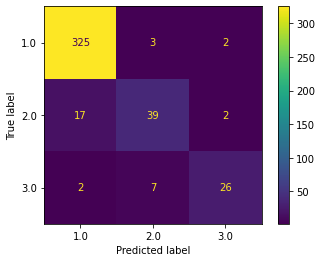

In [99]:
print_report(grid_knn, X_test, y_test)

              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00      1316
         2.0       1.00      0.99      1.00       234
         3.0       1.00      1.00      1.00       140

    accuracy                           1.00      1690
   macro avg       1.00      1.00      1.00      1690
weighted avg       1.00      1.00      1.00      1690



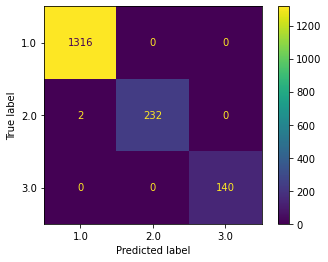

In [100]:
print_report(grid_knn, X_train, y_train)